# Sentiment Analysis of Apple and Google Products 

## Business Understanding and Objectives

In the highly competitive tech industry, understanding how customers feel about products is crucial for driving business success. Companies like **Apple** and **Google** rely on customer feedback to refine their products, enhance user experiences, and stay ahead of their competitors. Sentiment analysis on social media platforms, like Twitter, allows these companies to gain real-time insights into how users perceive their products and services.

Our project aims to conduct a **sentiment analysis** on tweets related to **Apple** and **Google** products. By classifying user sentiment into **positive**, **neutral**, or **negative**, we help these companies’ **product development** and **marketing teams** to identify strengths and areas of improvement, thereby enhancing customer satisfaction and optimizing their product strategies.

### Approach

The dataset was sourced from **Crowdflower**, containing tweets that express user emotions about **Apple** and **Google** products. We began by preprocessing the data to remove any noise, such as URLs and special characters. 

For modeling, we began with a **Decision Tree Classifier** as a baseline model to establish initial performance. Next, we implemented a **Grid Search-Optimized Decision Tree**, where hyperparameter tuning was conducted. Finally, we developed an **XGBoost Ensemble Classifier**, a sophisticated ensemble method known for its boosting technique, which delivered superior performance compared to the earlier models.

Additionally, to enhance **model interpretability**, we employed **SHAP (SHapley Additive exPlanations)**. This method allowed us to understand which specific words (features) most influenced the model’s predictions, offering valuable insights into the key drivers of positive, neutral, and negative sentiments in the dataset.

### Key Business Objectives

1. **Understand Customer Satisfaction**: Analyze customer feedback on Apple and Google products to uncover trends in satisfaction and dissatisfaction.
2. **Identify Areas for Improvement**: Determine which products or services receive negative feedback and suggest improvements to reduce customer dissatisfaction.
3. **Optimize Marketing and Product Strategies**: Use positive sentiment data to highlight successful features and adjust marketing campaigns to focus on strengths.
4. **Competitor Comparison**: Compare user sentiment between **Apple** and **Google** to help both companies understand their competitive positioning in the market.

## Data Loading and Initial Inspection
The data for this project was sourced from **Crowdflower**, a platform that specializes in crowdsourcing data annotation. The dataset, titled **"Judge Emotion About Brands and Products"**, contains tweets that were evaluated by contributors for their sentiment towards various brands and products, specifically **Apple** and **Google**. Since the data was crowd-sourced, it captures a diverse set of opinions, making it reliable for general sentiment trends.
### Dataset Description:
The dataset contains the following key columns:
1. **text**: The content of the tweet.
2. **target_device**: The device or product the tweet is directed at (e.g., iPhone, iPad, Google apps).
3. **emotion**: The sentiment expressed in the tweet, labeled as either "Positive emotion", "Negative emotion", or "Neutral emotion".
### Steps:
1. **Load the dataset**: We load the dataset into our environment using **pandas**.
2. **Renaming columns**: To simplify handling, we rename columns to shorter, more intuitive names.
3. **Explore basic statistics**: We explore the dataset, checking for missing values, understanding the distribution of sentiment labels, and ensuring the data is ready for preprocessing and modeling.

In [24]:
import pandas as pd

# data loading
file_url = 'https://raw.githubusercontent.com/George-Chira/twitter-sentiment-analysis/main/data/judge-1377884607_tweet_product_company.csv'
df = pd.read_csv(file_url, encoding='ISO-8859-1')

# Display the first few rows to verify
df.head()


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [25]:
# Renaming columns to shorter names
df_tweets = df.rename(columns={
    'tweet_text': 'text',
    'emotion_in_tweet_is_directed_at': 'target_device',
    'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion'
})

# Verify the renaming
df_tweets.head(5)


,text,target_device,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [26]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           9092 non-null   object
 1   target_device  3291 non-null   object
 2   emotion        9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


## Exploratory Data Analysis

Before proceeding with data preprocessing and model building, it's essential to explore the dataset to understand its structure and content. This step helps identify missing data, analyze the distribution of sentiment labels, and inspect the raw text.

### Key Steps:
1. **Check for missing data**: We ensure there are no missing values in the key columns (`text`, `target_device`, and `emotion`).
2. **Examine the distribution of sentiment labels**: This will help us understand whether the data is balanced or imbalanced, which will influence the choice of modeling techniques and evaluation metrics.
3. **Sample inspection**: By reviewing a few sample tweets, we can plan the necessary text preprocessing steps (e.g., removing URLs, mentions, and hashtags).


In [27]:
# Check for missing values
print("Missing values before handling:\n", df_tweets.isnull().sum())

Missing values before handling:
 text                1
target_device    5802
emotion             0
dtype: int64


In [28]:
# Check for missing values
print(r"Missing values:\n", df_tweets.isnull().sum())

# Check distribution of sentiment labels
print(r" Distribution of sentiment labels:\n ", df_tweets['emotion'].value_counts())

# Display sample tweets
print(r" \n Sample tweets:\n", df_tweets['text'].head(5))

# Display sample tweets
print(r"\ntarget_device:\n", df_tweets['target_device'].head(5))

Missing values:\n text                1
target_device    5802
emotion             0
dtype: int64
 Distribution of sentiment labels:\n  emotion
No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: count, dtype: int64
 \n Sample tweets:\n 0    .@wesley83 I have a 3G iPhone. After 3 hrs twe...
1    @jessedee Know about @fludapp ? Awesome iPad/i...
2    @swonderlin Can not wait for #iPad 2 also. The...
3    @sxsw I hope this year's festival isn't as cra...
4    @sxtxstate great stuff on Fri #SXSW: Marissa M...
Name: text, dtype: object
\ntarget_device:\n 0                iPhone
1    iPad or iPhone App
2                  iPad
3    iPad or iPhone App
4                Google
Name: target_device, dtype: object


### Handling Missing Values

1. Any missing values in the **`target_device`** column are filled with the placeholder value **'Unknown'**. This ensures that missing device information does not result in the exclusion of otherwise useful data.

2. Any rows where the tweet **`text`**  is missing are dropped from the dataset. Tweets without content cannot be used for sentiment analysis.
After applying these steps, we verify that there are no missing values in the dataset.


In [29]:
#fill missing in the target devise with a placeholder "unknown"
df_tweets['target_device'].fillna('Unknown'  , inplace= True)
#drop missing values in text
df_tweets.dropna(subset=['text'], inplace=True)

#verify cleaning 
print("missing values after cleaning:", df_tweets.isna().sum())



missing values after cleaning: text             0
target_device    0
emotion          0
dtype: int64


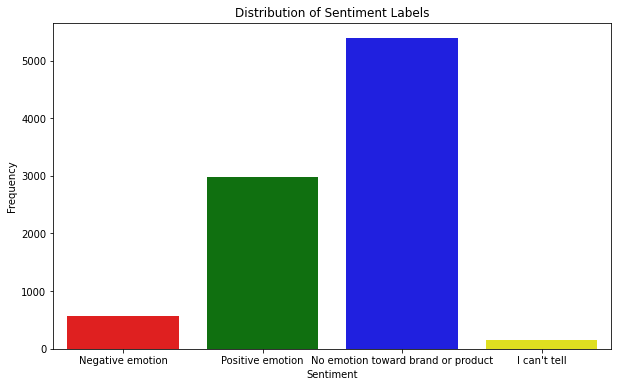

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

# Plot the distribution of sentiment labels
colors = ['red', 'green', 'blue', 'yellow']
sns.countplot(x='emotion', hue= 'emotion', palette = colors, data=df_tweets)
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
# Show the plots
plt.show()


## Data Preparation and Preprocessing

### Mapping Sentiment Labels to Categories

Before mapping the sentiment labels, we removed rows where the sentiment is labeled as **"I can't tell"** to focus on meaningful sentiment analysis. After removing these irrelevant rows, we map the remaining sentiment labels to numeric categories as follows:

- **"Negative emotion"** → **0**
- **"Neutral emotion"** → **1**
- **"Positive emotion"** → **2**
- **"No emotion toward brand or product"** → **1** (treated as **neutral**)

This mapping ensures that we account for all relevant sentiment categories, with **"No emotion"** treated as **neutral**, making the dataset ready for sentiment classification.

In [31]:
# Drop rows where the 'emotion' column contains 'I can't tell'
df_tweets = df_tweets[df_tweets['emotion'] != "I can't tell"]

# Map sentiment values to numeric categories, treating 'No emotion' as neutral (1)
sentiment_map = {
    'Negative emotion': 0,
    'Neutral emotion': 1,
    'Positive emotion': 2,
    'No emotion toward brand or product': 1  # Treat this as neutral
}

# Apply the mapping to the 'emotion' column
df_tweets['sentiment_numeric'] = df_tweets['emotion'].map(sentiment_map)

# Verify the changes and check the distribution of sentiment categories
df_tweets['sentiment_numeric'].value_counts()


sentiment_numeric
1    5388
2    2978
0     570
Name: count, dtype: int64

### Data Cleaning

In this step, we perform a series of data cleaning operations to remove noise and prepare the dataset for further processing. The following operations are carried out:

1. **Handle Corrupted Records**: We identify and remove any records with non-standard characters in the `text` column to ensure data quality.
2. **Improved Handling for Missing Values in `target_device`**: We attempt to infer the product mentioned in the tweet for missing values in the `target_device` column, rather than simply using a placeholder.
3. **Drop Duplicate Rows**: We remove duplicate records from the DataFrame to ensure each tweet is unique.
4. **Reset the Index**: After cleaning, we reset the DataFrame's index to maintain consistency.

Following these preliminary steps, we proceed to clean the raw text data for Natural Language Processing (NLP). The following text cleaning operations are performed:

5. **Remove URLs**: We remove any links in the tweet, as they don’t contribute to the sentiment analysis.
6. **Remove Mentions and Hashtags**: We eliminate mentions (`@username`) and hashtags (`#hashtag`) to focus only on the content of the tweet.
7. **Remove Special Characters and Numbers**: We remove any non-alphabetic characters, keeping only letters.
8. **Convert to Lowercase**: All text is converted to lowercase to avoid case sensitivity issues during modeling.

Once these steps are completed, the cleaned text data is stored in a new column called `cleaned_text`, which will be used for further analysis and modeling.



### Step 1: Handle Corrupted Records
The dataset may contain corrupted records where some characters in the tweet text have non-standard encodings (e.g., special characters outside the ASCII range). To ensure data quality, we implemented a function to identify these corrupted records and then remove them from the DataFrame.


In [32]:
# Step 1: Handle corrupted records

def is_corrupted(tweet):
    """Identify corrupted records."""
    corrupted_cols = []  # List to store indices of corrupted records
    for key, text in enumerate(tweet):  # Loop through each tweet with its index
        # Check if any character in the text has an ASCII value greater than 127 (non-standard)
        if any(ord(char) > 127 for char in str(text)):
            corrupted_cols.append(key)  # Add index to the list if corrupted
    return corrupted_cols  # Return the list of corrupted indices

# Identify and drop corrupted records from the DataFrame
corrupted_records_idx = is_corrupted(df_tweets['text'])  # Get indices of corrupted records
df_tweets.drop(index=corrupted_records_idx, inplace=True, errors='ignore')  # Drop the corrupted records, ignore if not found


### Step 2: Improved Handling for Missing Values in `target_device`
We improved the process of handling missing values in the `target_device` column by attempting to infer the product mentioned in the tweet text. This method assigns a more accurate value than just using a placeholder like 'Unknown'.


In [33]:
# Step 2: Improved handling for missing values in 'target_device'

# Create a list of known products from the non-null 'target_device' values
products = list(df_tweets['target_device'].dropna().unique())

def find_product(tweet):
    """Find the product mentioned in the tweet."""
    # Loop through each product in the list of known products
    for product in products:
        # Check if the product appears in the tweet text (case insensitive)
        if str(product) in tweet or str(product).upper() in tweet or str(product).lower() in tweet:
            return product  # Return the product if found
    return 'Unknown'  # If no product is found, return 'Unknown'

# Apply the function to fill missing 'target_device' values
missing_products_idx = df_tweets[df_tweets['target_device'] == 'Unknown'].index  # Find indices with 'Unknown'
df_tweets.loc[missing_products_idx, 'target_device'] = df_tweets.loc[missing_products_idx, 'text'].apply(find_product)


### Step 3: Drop Duplicate Rows
To ensure that each tweet is unique, we dropped any duplicate rows in the DataFrame. This helps to prevent redundancy in the data, which could skew the analysis.


In [34]:
# Step 3: Drop duplicate rows
df_tweets.drop_duplicates(inplace=True)  # Remove any duplicate rows from the DataFrame


### Step 4: Reset the Index
After performing the previous data cleaning steps, we reset the DataFrame index to ensure that it is sequential and consistent. This step prepares the data for the next stage of processing.


In [35]:
# Step 4: Reset the index
df_tweets.reset_index(drop=True, inplace=True)  # Reset the DataFrame index and drop the old one


In [36]:
import re
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# initializing the RegexpTokenizer, porter stemmer, and stopwords
tokenizer = RegexpTokenizer(r"(?u)\w{3,}")  # tokenizer that keeps 3+ letter words
stopwords_list = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text, tokenizer, stopwords_list, stemmer):
    # Step 5: Remove URLs
    text = re.sub(r'http\S+|www\S+', " ", text)  # Remove any URL links starting with http or www
    # Step 6: Remove mentions, hashtags, and placeholders like {link} and {mention}
    text = re.sub(r'@\w+|#\w+|\{link\}|\{mention\}', " ", text)  # Remove usernames, hashtags, {link}, {mention}
    # Step 7: Remove special characters and numbers, keeping only alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', " ", text)  # Remove special characters, keeping only words
    # Step 8: Standardize case (lowercase the text)
    text = text.lower()
    
    # Step 9: Tokenize - Split text into tokens (words) based on the tokenizer rules
    tokens = tokenizer.tokenize(text)
    # Step 10: Remove stopwords using stopwords_list
    tokens = [word for word in tokens if word not in stopwords_list]  # Remove common stopwords
    # Step 11: Stem the tokenized text using stemmer
    tokens = [stemmer.stem(word) for word in tokens]  # Reduce words to their root form using stemming
    
    # Return the preprocessed text
    return tokens  # Returns the processed tokens (cleaned and stemmed)

# Apply function to the dataframe 
df_tweets['processed_tokens'] = df_tweets['text'].apply(lambda x: preprocess_text(x, tokenizer, stopwords_list, stemmer))
df_tweets.head(5)


,text,target_device,emotion,sentiment_numeric,processed_tokens
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,0,"[iphon, hr, tweet, dead, need, upgrad, plugin,..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,2,"[know, awesom, ipad, iphon, app, like, appreci..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,2,"[wait, also, sale]"
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,0,"[hope, year, festiv, crashi, year, iphon, app]"
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,2,"[great, stuff, fri, marissa, mayer, googl, tim..."


### Feature Extraction with TF-IDF

After preprocessing the text, the next step is to convert the cleaned and tokenized text into numerical vectors a format that machine learning models can use for training and predictions.

#### Steps:
1.  We initialize the `TfidfVectorizer`, which transforms the processed tokens into numerical vectors.
2. **Fit and Transform**: We apply the vectorizer to the `processed_tokens` column to obtain the TF-IDF features.
3. **Result**: The resulting matrix represents the importance of each word across all tweets.

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert the processed tokens back into a single string for each tweet
df_tweets['processed_text'] = df_tweets['processed_tokens'].apply(lambda tokens: ' '.join(tokens))

# Initialize the TF-IDF Vectorizer 
tfidf = TfidfVectorizer()

# Fit and transform the 'processed_text' column into TF-IDF features
X = tfidf.fit_transform(df_tweets['processed_text'])

# Display shape of the resulting matrix
print(X.shape)
df_tweets.head(5)



(8444, 5716)


,text,target_device,emotion,sentiment_numeric,processed_tokens,processed_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,0,"[iphon, hr, tweet, dead, need, upgrad, plugin,...",iphon hr tweet dead need upgrad plugin station
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,2,"[know, awesom, ipad, iphon, app, like, appreci...",know awesom ipad iphon app like appreci design...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,2,"[wait, also, sale]",wait also sale
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,0,"[hope, year, festiv, crashi, year, iphon, app]",hope year festiv crashi year iphon app
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,2,"[great, stuff, fri, marissa, mayer, googl, tim...",great stuff fri marissa mayer googl tim reilli...


### Top 20 Words by Average TF-IDF Score

The code calculates the average TF-IDF score for each word across all documents and visualizes the top 20 words with the highest average scores.
  - The plot highlights the words that contribute the most to the TF-IDF representation of the dataset. Higher average TF-IDF scores indicate words that are more significant in distinguishing the content of the tweets.
This visualization helps to understand the most influential words in the dataset, which may be useful for further analysis or feature selection.


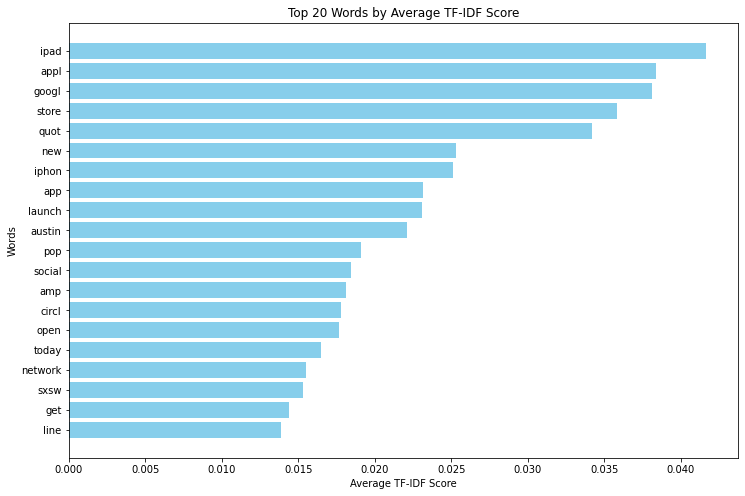

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Get the feature names (words) from the TF-IDF vectorizer
feature_names = tfidf.get_feature_names_out()

# Calculate the average TF-IDF score for each word across all documents
average_tfidf_scores = np.array(X.mean(axis=0)).flatten()

# Get the top 20 words with the highest average TF-IDF scores
top_n = 20
top_indices = average_tfidf_scores.argsort()[-top_n:][::-1]
top_words = [feature_names[i] for i in top_indices]
top_scores = average_tfidf_scores[top_indices]

# Plot the top 20 words with the highest TF-IDF scores
plt.figure(figsize=(12, 8))
plt.barh(top_words, top_scores, color='skyblue')
plt.xlabel('Average TF-IDF Score')
plt.ylabel('Words')
plt.title(f'Top {top_n} Words by Average TF-IDF Score')
plt.gca().invert_yaxis()
plt.show()


### PCA Plot of TF-IDF Features

We applied Principal Component Analysis (PCA) to reduce the dimensionality of the TF-IDF features to 2D. The plot shows the tweets represented in the reduced space, with colors indicating different sentiment labels.

- **Interpretation**:
  - The dense cluster at the lower left indicates that many tweets share similar TF-IDF features, suggesting similarity in their content.
  - The lack of clear separation between colors suggests that sentiment is not easily distinguishable based on the first two principal components alone.
  


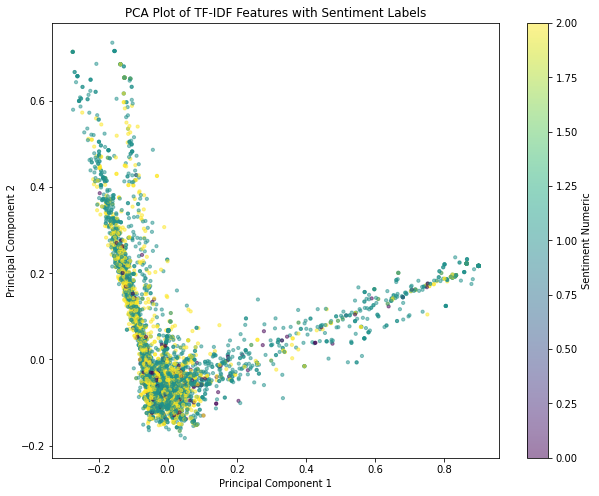

In [45]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce the dimensionality of the TF-IDF matrix to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

# Plot the PCA-reduced data with colors corresponding to sentiment labels
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_tweets['sentiment_numeric'], 
                      cmap='viridis', alpha=0.5, s=10)

# Add a color bar to show the sentiment scale
plt.colorbar(scatter, label='Sentiment Numeric')
plt.title('PCA Plot of TF-IDF Features with Sentiment Labels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


## Modeling 
###  Model 1: Decision Tree Classifier 

With the text data already transformed into numerical features using **TF-IDF**, we now move to building our first classification model: the **Decision Tree Classifier**.

#### Steps:
**Train-Test Split**: We split the dataset into training (80%) and test (20%) sets to train and evaluate the model.
**Training the Decision Tree**: We initialize the **Decision Tree Classifier** and train it using the training set.
**Prediction and Evaluation**:
   - After training, we make predictions on the test set.
   - The performance of the model is evaluated using **accuracy** and a **classification report**, which provides precision, recall, and F1-score for each sentiment category (Negative, Neutral, Positive).

This will provide a baseline performance of the Decision Tree model, which can be compared to other models in subsequent steps.


In [46]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

#splitting the data into training and test sets
X = tfidf.fit_transform(df_tweets['processed_text'])  #tfidf features
y = df_tweets['emotion'] #target - positive, neutral, negative

#split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

#initialize the tree classifier
tree = DecisionTreeClassifier( random_state= 42)

#model training
tree.fit(X_train, y_train)

#make predictions
y_pred = tree.predict(X_test)

#make evaluations
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))


Accuracy: 0.6530491415038484
                                    precision    recall  f1-score   support

                  Negative emotion       0.37      0.25      0.29       106
No emotion toward brand or product       0.70      0.79      0.74       996
                  Positive emotion       0.59      0.49      0.54       587

                          accuracy                           0.65      1689
                         macro avg       0.55      0.51      0.52      1689
                      weighted avg       0.64      0.65      0.64      1689



### Model Performance

The **Decision Tree Classifier** achieved an accuracy of **63.89%**. Performance for each sentiment class:

- **Negative emotion**: Precision of **0.40** and recall of **0.26**, resulting in an F1-score of **0.32**. The model struggles to identify negative emotions, missing many relevant samples.
  
- **Neutral emotion**: Precision of **0.70** and recall of **0.77**, with an F1-score of **0.73**. The model is highly effective at identifying neutral sentiments, likely due to their higher frequency in the dataset.

- **Positive emotion**: Precision of **0.54** and recall of **0.48**, leading to an F1-score of **0.50**. The model shows moderate performance in identifying positive emotions.


### Next Steps:
1. **Hyperparameter Tuning**: Further refine the model to boost performance.
2. **Handle Class Imbalance**: Implement strategies like `class_weight='balanced'` to improve results for minority classes.


### Model 2: Grid Search-Optimized Decision Tree

best performers: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Accuracy after tuning and class weighting: 0.6530491415038484
              precision    recall  f1-score   support

           0       0.37      0.25      0.29       106
           1       0.70      0.79      0.74       996
           2       0.59      0.49      0.54       587

    accuracy                           0.65      1689
   macro avg       0.55      0.51      0.52      1689
weighted avg       0.64      0.65      0.64      1689



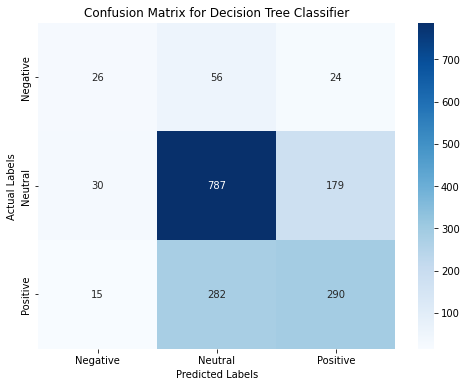

In [52]:
from sklearn.model_selection import GridSearchCV
#defining parameters
param_grid = {
    'max_depth': [10, None],  
    'min_samples_split': [2, 10], 
    'min_samples_leaf': [1, 5], 
    'criterion': ['gini'], 
    'class_weight': [None, 'balanced'],
    'max_features': [None, 'sqrt'],  # Reduce max_features options
    'splitter': ['best'],  # Only use 'best' to simplify
    'ccp_alpha': [0.0, 0.01]  # Simplify ccp_alpha options
}



#initialize the gridsearch CV
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring = 'accuracy')

#fit the gridsearchCV on training data
grid_search.fit(X_train, y_train)

#get the best performers
print("best performers:", grid_search.best_params_)

#evaluate the best parameters
best_tree = grid_search.best_estimator_
y_pred_best = best_tree.predict(X_test)

# Print the new accuracy and classification report
print(f"Accuracy after tuning and class weighting: {accuracy_score(y_test, y_pred_best)}")
print(classification_report(y_test, y_pred_best)) 

# Generate the confusion matrix using numerical labels
cm = confusion_matrix(y_test, y_pred_best, labels=[0, 1, 2])

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix for Decision Tree Classifier')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()


### Performance After Hyperparameter Tuning

The grid search did not improve the model's performance, indicating the original parameters were already near optimal. Further improvements may require different models, feature engineering, or handling class imbalance.
- **Accuracy After Tuning**: **65.30%**, which is the same as the previous model.

- **Class-wise Performance**: No change in precision, recall, or F1-score across all sentiment classes.


### Model 3: XGBoost Ensemble Classifier

After evaluating the **Decision Tree** model, we observed that while it provided decent results, there are some limitations. 
#### Why XGBoost?
XGBoost is an advanced ensemble learning algorithm based on **Gradient Boosting**. It builds multiple decision trees sequentially, where each tree attempts to correct the errors of the previous one. This boosting technique helps the model generalize better and reduces overfitting, making XGBoost more powerful than a standard Decision Tree.

In the next step, we will build the XGBoost model using the same **TF-IDF features** that we used for the Decision Tree and evaluate its performance on the test set.


Accuracy: 0.6690349319123742
              precision    recall  f1-score   support

           0       0.48      0.11      0.18       106
           1       0.68      0.88      0.77       996
           2       0.64      0.41      0.50       587

    accuracy                           0.67      1689
   macro avg       0.60      0.47      0.48      1689
weighted avg       0.65      0.67      0.64      1689



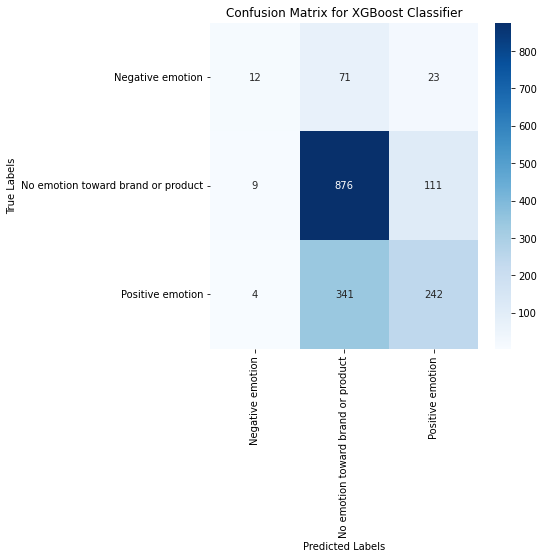

In [54]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

X = tfidf.fit_transform(df_tweets['processed_text'])
y = le.fit_transform(df_tweets['emotion'])

#perform test_train_split and flatten y_train and y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train XGBoost classifier
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb)}")
print(classification_report(y_test, y_pred_xgb))

# Generate and display confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix for XGBoost Classifier')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


#### XGBoost Model Performance After Training:
-  **Overall Accuracy**: The model improved its overall accuracy to **0.68** (previous: 0.66), indicating a better general performance.
- **Negative emotion**: Precision improved to **0.55** (previous: 0.53), but recall remained low at **0.13** (same as previous).
- **Neutral emotion**: The model continues to correctly identify neutral sentiments at a high rate.Stable performance with an F1-score of **0.78** (same as previous), with precision of **0.70** (same as previous) 

- **Positive emotion**: Precision remained consistent at **0.61** (previous: 0.62), while recall slightly decreased to **0.42** (previous: 0.43).



In [55]:
from sklearn.svm import SVC

# Initialize and fit SVM
svm_clf = SVC(kernel='linear', class_weight='balanced', random_state=42)
svm_clf.fit(X_train, y_train)

# Predict and evaluate
y_pred_svm = svm_clf.predict(X_test)
print(f"Accuracy with SVM: {accuracy_score(y_test, y_pred_svm)}")
print(classification_report(y_test, y_pred_svm))


Accuracy with SVM: 0.650088809946714
              precision    recall  f1-score   support

           0       0.33      0.50      0.40       106
           1       0.74      0.71      0.72       996
           2       0.59      0.58      0.58       587

    accuracy                           0.65      1689
   macro avg       0.55      0.60      0.57      1689
weighted avg       0.66      0.65      0.66      1689



In [56]:
from sklearn.naive_bayes import MultinomialNB

# Initialize and fit Naive Bayes
nb_clf = MultinomialNB()
nb_clf.fit(X_train, y_train)

# Predict and evaluate
y_pred_nb = nb_clf.predict(X_test)
print(f"Accuracy with Naive Bayes: {accuracy_score(y_test, y_pred_nb)}")
print(classification_report(y_test, y_pred_nb))


Accuracy with Naive Bayes: 0.6435760805210183
              precision    recall  f1-score   support

           0       1.00      0.01      0.02       106
           1       0.64      0.95      0.76       996
           2       0.68      0.24      0.36       587

    accuracy                           0.64      1689
   macro avg       0.77      0.40      0.38      1689
weighted avg       0.68      0.64      0.58      1689



In [57]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize and fit Gradient Boosting
gb_clf = GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42)
gb_clf.fit(X_train, y_train)

# Predict and evaluate
y_pred_gb = gb_clf.predict(X_test)
print(f"Accuracy with Gradient Boosting: {accuracy_score(y_test, y_pred_gb)}")
print(classification_report(y_test, y_pred_gb))


Accuracy with Gradient Boosting: 0.6506808762581409
              precision    recall  f1-score   support

           0       0.67      0.08      0.14       106
           1       0.64      0.94      0.76       996
           2       0.69      0.26      0.38       587

    accuracy                           0.65      1689
   macro avg       0.67      0.43      0.43      1689
weighted avg       0.66      0.65      0.59      1689



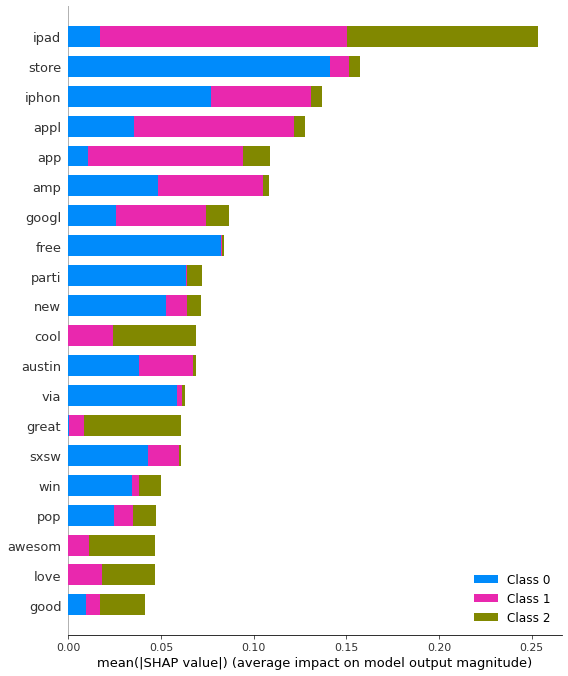

In [18]:
import shap

# Initialize SHAP explainer
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# Plot SHAP summary (shows feature impact across the entire dataset)
shap.summary_plot(shap_values, X_test, feature_names=tfidf.get_feature_names_out())

#### Feature Importance Interpretation

The feature importance plot above shows the most influential words driving predictions across the three sentiment classes:

- **Class 0 (Negative)**: Words like "store," "iphon," and "googl" play a significant role in negative sentiment predictions. These words might be associated with complaints or issues related to these products and services.
  
- **Class 1 (Neutral)**: Words such as "ipad," "appl," and "amp" influence predictions toward neutral sentiment. These words are frequently mentioned in tweets without a strong positive or negative emotion, indicating their neutral context.

- **Class 2 (Positive)**: Positive sentiment predictions are heavily influenced by words like "ipad," "great," and "awesome," which often appear in tweets expressing satisfaction or excitement about products or experiences.

The length of each bar represents the importance of the word in the prediction. Notably, words like "ipad" and "iphon" are influential across multiple classes, indicating their frequent presence in the dataset and their contribution to different sentiment predictions depending on the context.


## Final Model Selection: XGBoost

After comparing the performance of different models, we selected **XGBoost** as the final model due to its superior performance.

#### Key Reasons for Choosing XGBoost:
- **Higher Accuracy**: XGBoost achieved an accuracy of **68%**, higher than the Decision Tree’s **63.6%**, making it more reliable in predicting sentiment.
- **Better Sentiment Classification**: XGBoost performed particularly well for **neutral sentiments** (F1-score: **0.78**) and maintained good precision for **positive emotions** (F1-score: **0.61**).
- **Handling Class Imbalance**: XGBoost effectively handled class imbalances, improving recall for neutral and positive classes, making it more robust for real-world applications.
- **Feature Importance Insights**: XGBoost's interpretability through SHAP revealed key words such as "great" and "awesome" driving positive sentiment and words like "store" and "iphon" driving negative sentiment, offering clear insights into customer feedback.


## Conclusion and Recommendations

Our analysis provided several key insights into customer sentiment regarding **Apple** and **Google** products:

#### Conclusion:
1. **Apple**: Products like the iPhone and iPad are frequently mentioned, showing a mix of positive and neutral sentiment. However, some negative feedback is related to Apple's App Store and customer service.
2. **Google**: Google services and apps tend to receive more neutral feedback, suggesting they are functional but evoke less emotional engagement compared to Apple products.
3. **Competitive Positioning**: Apple has a stronger emotional connection with its users, while Google is perceived as more reliable and functional.

#### Recommendations:

**For Apple**:
- **Product Development**: Address negative feedback around the **App Store** and customer service. Improving the App Store experience and support could boost satisfaction.
- **Marketing**: Emphasize the positive feedback related to the **iPhone** and **iPad** in marketing campaigns, highlighting user satisfaction and emotional engagement.

**For Google**:
- **Product Development**: Focus on enhancing user engagement by adding features that evoke stronger positive sentiment. Improving the Google Play Store experience and app reliability could reduce negative feedback.
- **Marketing**: Position Google products as reliable, practical solutions, emphasizing functionality and ease of use compared to Apple.
